In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
import os
import numpy as np
import re
import statistics
from classes import Speed, Time, Direction

In [2]:
WEATHER_DIR = "./weather/"
CITY_SUFFIXES = ["_melbourne", "_sydney", "_adelaide", "_brisbane"]
CITY_DIRS = [WEATHER_DIR + "weather" + suffix + ".csv" for suffix in CITY_SUFFIXES]

#loads city weather dfs
mel, syd, adl, brs = [pd.read_csv(city_dir) for city_dir in CITY_DIRS]


#loads price df
price_demand = pd.read_csv(WEATHER_DIR + 'price_demand_data.csv')


In [3]:

#these dont have number values . N, NW, SSE etc...
direction_columns = [
    "Direction of maximum wind gust ",
    "9am wind direction",
    "3pm wind direction"
]

speed_columns = [
    "Speed of maximum wind gust (km/h)",
    "9am wind speed (km/h)",
    "3pm wind speed (km/h)"
]

pressure_columns = [
    "9am MSL pressure (hPa)",
    "3pm MSL pressure (hPa)"
]

temp_columns = [
    "Minimum temperature (°C)",
    "Maximum temperature (°C)",
    "9am Temperature (°C)",
    "3pm Temperature (°C)"
]

humidity_columns = [
    "9am relative humidity (%)",
    "3pm relative humidity (%)"
]

mm_columns = [
    "Rainfall (mm)",
    "Evaporation (mm)"
]

oktas_columns = [
    "9am cloud amount (oktas)",
    "3pm cloud amount (oktas)"
]



In [4]:
directions = [Direction(mel[series]).process() for series in direction_columns]
speeds = [Speed(mel[series]).process() for series in speed_columns]

unprocessed = [[mel[col] for col in cols] for cols in [pressure_columns, temp_columns, humidity_columns, mm_columns, oktas_columns]]
cols_to_plot = [directions, speeds, [Time(mel["Time of maximum wind gust"]).sec_after_midnight()],*unprocessed]

In [5]:
num_rows = 4
num_cols = 2

time_differences = Time(mel["Date"]).days_after_min()

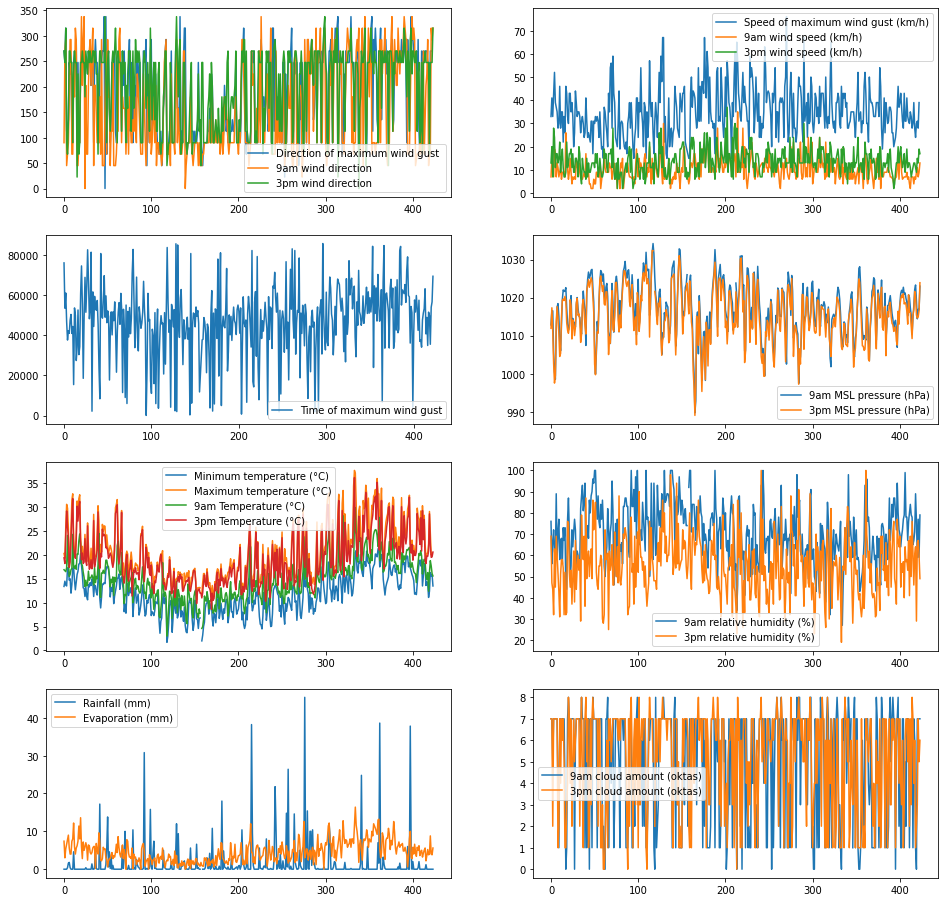

In [6]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(16,16))
#excludes date field

count = 0
for i in range(0,num_rows):
    for j in range(num_cols):
        
        [ax[i,j].plot(time_differences.iloc[series.index], series) for series in cols_to_plot[count]]
        ax[i,j].legend([col.name for col in cols_to_plot[count]])
        count += 1
        if(count == len(cols_to_plot)):
            break
    if(count == len(cols_to_plot)):
        break

In [7]:
def get_outlier1(df, col):
    """ Takes a dataframe and a colum name
        Returns the index of the ones that are indentified as outliers
        Note: outliers identified based on the change in values
        therefore only work for values that are considered more or less continuous
        (data that are dependent on what happen the day before)
        e.g. temperature anti-example rainfall"""

    distance_lst=[df[col][i] - df[col][i-1] for i in range(1, len(df[col]))]
    Q1=np.nanpercentile(distance_lst, 25)
    Q3=np.nanpercentile(distance_lst, 75)
    interquartile_range=1.5*(Q3-Q1)
    upper_bound=Q3+interquartile_range
    lower_bound=Q1-interquartile_range
    outliers_index=[]
    for i in range(0,len(distance_lst)):
        if distance_lst[i]>upper_bound or distance_lst[i]<lower_bound:
            outliers_index.append(i+1)  
    return outliers_index

In [8]:
price_demand.tail()
price_demand.sort_values(by=["REGION","SETTLEMENTDATE"], inplace=True)
price_demand.reset_index(inplace=True,drop=True)
price_demand.groupby(['REGION']).count()

,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE
REGION,,,
NSW1,60000,60000,60000
QLD1,60000,60000,60000
SA1,60000,60000,60000
VIC1,60000,60000,60000


In [9]:
'''create a new dataframe where the total demand for each day is the average of all 
   and pricesurge is true if it's true for any time of the day'''

'''saved to a file named price_demand_sorte
   0-59999 NSW 60000-11999 QLD  12000-17999 SA    18000-23999 VIC'''

settlementdate_format=r'\d{4}/\d{2}/\d{2}'
settlementdate=list()
for dates in price_demand['SETTLEMENTDATE']:
    match=re.search(settlementdate_format, dates)
    if match.group(0) not in settlementdate:
        settlementdate.append(match.group(0))
price_demand_dated =pd.DataFrame(columns=price_demand.columns)
start_row=0
while start_row<239999:
    end_row=start_row
    BOOL=price_demand['PRICESURGE'][start_row]
    while re.search(settlementdate_format, price_demand['SETTLEMENTDATE'][end_row]).group(0)==re.search(settlementdate_format, price_demand['SETTLEMENTDATE'][start_row]).group(0) and price_demand['REGION'][start_row]==price_demand['REGION'][end_row]:
        if price_demand['PRICESURGE'][end_row]:
            BOOL=True
        end_row+=1
    price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
                               "SETTLEMENTDATE": re.search(settlementdate_format, price_demand['SETTLEMENTDATE'][start_row]).group(0),
                               "TOTALDEMAND": round(statistics.mean(price_demand['TOTALDEMAND'][start_row:end_row]),2),
                               "PRICESURGE": BOOL}, ignore_index=True)
    start_row=end_row+1


/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p

/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_demand_dated=price_demand_dated.append({"REGION": price_demand['REGION'][start_row],
/var/folders/m7/lpsk9bbj6mlcxyvpcl_65n6c0000gp/T/ipykernel_1367/1928149540.p